<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_01_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gutenbergpy # https://github.com/raduangelescu/gutenbergpy to get access to full texts of books

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for httpsproxy-urllib2: filename=httpsproxy_urllib2-1.0-py3-none-any.whl size=29269 sha256=cc2e563961f6f6f0568f3bcdcfab000eba9d1cc440b06286056907c147e32dea
  Stored in directory: /root/.cache/pip/wheels/91/04/37/b7080e0cfe33a8bc79ff0082159cea767f9145a5a713b501a3
Successfully built httpsproxy-urllib2


After a package has been installed, we still need to *import* it.

In [4]:
target = 1342 # this one is Jane Austen's Price and Prejudice
import gutenbergpy.textget
raw  = gutenbergpy.textget.get_text_by_id(target) # access the content
text = gutenbergpy.textget.strip_headers(raw) # remove header metadata
count = 50 # how many characters we wish to see
print(text[:count]) 
print(text[-count:]) 

b'\n\n\n\nTHERE IS AN ILLUSTRATED EDITION OF THIS TITLE '
b'ire, had been the means of\n      uniting them.\n\n\n\n'


That clearly is not the beginning of the book itself. Let's scroll up and down on the [file itself on the browser](https://www.gutenberg.org/files/1342/1342-0.txt) to identify where the content itself starts and ends.

In [5]:
s = text.decode("utf-8") # get a string from the byte sequence
marker = 'CONTENTS'
startPosition = s.index(marker) + len(marker)
content = s[startPosition:]
print(content[:count]) # beginning



  Chapter 1

  Chapter 2

  Chapter 3

  Chapter


Let's try to get the individual chapters separated as a way to practice handling a larger piece of text that is composed of smaller entities.

In [6]:
chapters = content.split('Chapter ')
print(len(chapters), 'potential chapters')

123 potential chapters


The chapter list itself is now creating ghost chapters. Let's discard all those that only consist of the chapter number and nothing else by actually eliminating all digits *before* we split the text. This is a wonderful opportunity to bring aboard *regular expressions*.

In [7]:
import re # a regular-expression library
nodigits = re.sub(r'[0-9]+', '', content)
print('No digits:', nodigits[:count])
clean = re.compile(r'\s+') # also combine any kind of repeated whitespace into a single space
ok = clean.sub(' ', nodigits)
print('Cleaned:', ok[:count])
potential = ok.split('Chapter ')
stripped = [ candidate.strip().lstrip() for candidate in potential ] # remove leading and trailing space 
real = [ s for s in stripped if len(s) > 0 ] # keep only the ones with content
print(len(real), 'real chapters')
print(real[0][:count])

No digits: 

  Chapter 

  Chapter 

  Chapter 

  Chapter 


Cleaned:  Chapter Chapter Chapter Chapter Chapter Chapter C
61 real chapters
It is a truth universally acknowledged, that a sin


Now, let's try to characterize each chapter by looking at the frequencies of the words it contains. 

In [8]:
import operator
for chapter in real:
  freq = { w : chapter.count(w) for w in chapter.split() } # build a dictionary
  top = max(freq.items(), key = operator.itemgetter(1))[0] # the most frequent word
  longest = max(freq.keys(), key = len) # the longest word
  print(top, longest)

a three-and-twenty
a circumspection.
a brother-in-law,
a characteristic.
a self-complacency
a superciliousness
a breakfast-parlour,
a accomplishments,”
a self-consequence,
a readily—easily—to
a yielding—certainly
a intelligence—Elizabeth
a variance.—‘There,
a accomplishments
a parsonage-house,
a agreeable—allowing
a misrepresented
a self-gratulation;
a dear!—yes—certainly.
a breakfast-room,
a accomplishments;
a Charlotte—impossible!”
a self-gratulation
a disinterestedness
a inconsistencies
a fellow-creatures
a fellow-travellers
a affectionately
a self-importance,
a Hertfordshire—paid
a Hertfordshire—and,
a understanding—though
a questions—about
a poverty—comparative
a circumstances—and
a impartiality—deliberated
a recollections.
a unfortunate—but
a prettier-coloured
a disappointment!”
a hard-heartedness
a inconveniences—cheerfulness
a respectable-looking
a self-consequence
a agreeable-looking
a certain—absolutely
a twelvemonth—she
a brother-in-law’s
a breakfast-room;
a brother-in-law,


We have identified two problems: the article *a* is hiding all the *meaningful* words because it is so common, and punctuation is creating combinations of words. For the latter, we should get rid of it by replacing all punctuation with a space and then again compressing all repeated spaced into a single one. For the former, we will use a predefined stopword list.

In [33]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
skip = stopwords.words('english')
print('a' in skip, 'by' in skip, 'she' in skip)

True True True


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
from string import punctuation
for chapter in real:
  nopunct = chapter.translate(str.maketrans(punctuation, ' ' * len(punctuation))) # substitute with space
  ok = clean.sub(' ', nopunct) # in case we made repeated spaces
  words = ok.split()
  freq = { w : words.count(w) for w in words if w.lower() not in skip } # build a dictionary of the non-stopwords
  top = max(freq.items(), key = operator.itemgetter(1))[0] # the most frequent word
  longest = max(freq.keys(), key = len) # the longest word
  print(top, longest)

” neighbourhood
” circumspection
Mr Hertfordshire
Bingley recommendation
” what—something
” superciliousness
” Jones—therefore
” accomplishments
” acknowledgments
” readily—easily—to
” yielding—certainly
would intelligence—Elizabeth
” disrespectful
” accomplishments
Mr obsequiousness
” agreeable—allowing
Mr misrepresented
” kingdom—provided
” Hunsford—between
” disappointment
” accomplishments
Mr Charlotte—impossible
Mr congratulations
” disinterestedness
” inconsistencies
” correspondence
” uncompanionable
” affectionately
” speaking—stating
Mr Hertfordshire—paid
” Hertfordshire—and
” understanding—though
” questions—about
” poverty—comparative
could circumstances—and
could impartiality—deliberated
” discreditable
” unfortunate—but
” purchases—“Look
” disappointment
” congratulations
Elizabeth inconveniences—cheerfulness
” communicativeness
Darcy interpretation
Miss character—there
” certain—absolutely
” twelvemonth—she
” condescendingly
” congratulations
could acknowledgments
” congr

Better, yes, but the non-ASCII punctuation like the angled quotes still remains, causing problems, and we have a need for custom stopwords like *I* and *Mr*.

In [61]:
skip += [ 'i', 'mr', 'miss', 'mrs', 'lady', 'esq', 'ah', 'oh', 'us', 'go', 'st', 'de', 'one', 'two', 'ten', 'man', 'sir' ]
from string import printable # this does not contain mdash & those angled quotes 
print('OK:', printable)
nonprint = f'[^{re.escape(printable)}]'

OK: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [66]:
for chapter in real:
  nopunct = chapter.translate(str.maketrans(punctuation, ' '*len(punctuation)))
  better = re.sub(nonprint, ' ', nopunct)
  ok = clean.sub(' ', better) # in case we made repeated spaces
  words = ok.split()
  freq = { w : words.count(w) for w in words if w.lower() not in skip } # now with ours on the skip list
  top = max(freq.items(), key = operator.itemgetter(1))[0] 
  longest = max(freq.keys(), key = len) 
  shortest = min(freq.keys(), key = len) 
  print(top, longest, shortest)

dear neighbourhood may
Bennet circumspection hat
Bingley Hertfordshire ask
Bingley recommendation saw
said particularly Yes
would superciliousness un
said acknowledgment c
Bingley accomplishments six
Bingley acknowledgments met
Darcy correspondents day
Darcy inconsistencies ran
Elizabeth conscientiously beg
Bennet disrespectful th
Bennet accomplishments say
Collins obsequiousness te
Darcy superintendence set
could misrepresented day
Darcy congratulations se
would recommendation day
Collins disappointment end
Jane accomplishments end
Collins disapprobation day
Bennet congratulations put
Jane disinterestedness put
Jane inconsistencies day
Elizabeth correspondence say
Elizabeth uncompanionable day
Charlotte affectionately La
Catherine condescension see
Collins entertainment met
Darcy Hertfordshire add
Elizabeth disappointment te
Darcy inconveniences odd
Darcy misrepresentation end
could representation yet
could incomprehensible may
could discreditable see
Elizabeth indispensably met
would

We could assume that words that *only* appear with an initial uppercase are *names* and that the words that *sometimes* appear with an initial uppercase simply happen to be at the start of a sentence and should be made all lowercase.

Also some of the shorest words are suspicious, the one-letter words are probably middle initials or something of that sort. We could just limit to words of at least three letters each.

In [67]:
words = set() # let's collect all the words
for chapter in real:
  nopunct = chapter.translate(str.maketrans(punctuation, ' '*len(punctuation)))
  better = re.sub(nonprint, ' ', nopunct)
  ok = clean.sub(' ', better) # in case we made repeated spaces
  words.update(set(better.split())) # include these new words in the set

names = set()
regular = set()
for w in words:
  if len(w) < 3:
    continue # too short for our taste
  u = w.upper() # all uppercase version
  l = w.lower() # all lowercase version
  if w == u: # the word WAS all uppercase
    w = l.capitalize() # just a capital initial, then
  if l in skip or u in skip or w in skip:
    continue # ignore stop words
  if l in words: # not a name since it also appears in lowercase
    regular.add(l) # only keep the lowercase version
  else:
    names.add(w)
print(names)

{'Clapham', 'Clarke', 'Implacable', 'Lewis', 'Edward', 'Spanish', 'Eliza', 'Edw', 'Matlock', 'Caroline', 'Denny', 'Jones', 'Britain', 'Bingley', 'Reynolds', 'Birmingham', 'Barnet', 'Chatsworth', 'Eastbourne', 'Lakes', 'Friday', 'Georgiana', 'Oakham', 'Bennets', 'Chamberlayne', 'Dale', 'November', 'Charles', 'Fitzwilliam', 'Tease', 'Ramsgate', 'Courier', 'Harringtons', 'Carter', 'Younge', 'Phillip', 'January', 'Christian', 'June', 'England', 'Westerham', 'Kenilworth', 'Wickham', 'Commerce', 'Maria', 'Darcy', 'Mama', 'Phillipses', 'Blenheim', 'Warwick', 'Hertfordshire', 'Bakewell', 'Hatfield', 'Longbourn', 'George', 'Italian', 'Theatre', 'Hurst', 'Brighton', 'Derbyshire', 'Catherine', 'Thursday', 'September', 'Richard', 'Watson', 'Annesley', 'Webbs', 'Louisa', 'Haggerston', 'Lydia', 'Tuesday', 'Howsoever', 'Bourgh', 'Easter', 'Wednesday', 'February', 'Scotch', 'Kent', 'Netherfield', 'July', 'Liverpool', 'Saturday', 'Archbishop', 'Lucas', 'Lucases', 'James', 'April', 'Meryton', 'London', 

That includes names of months and days of the week in English. Let´s make those into stop words, too.

In [68]:
import calendar
months = list(calendar.month_name)[1:] # skip the initial ''
days = list(calendar.day_name)
omit =  months + days 
omit += [ m[:4] for m in months ] # Sept etc
omit += [ m[:3] for m in months ] # Feb etc
omit += [ d[:3] for d in days ] # Fri etc
omit = set(omit) # remove repeated entries
print('Before', len(names))
print(names & omit) # intersection
names -= omit # set difference
print('After', len(names))

Before 171
{'September', 'October', 'Friday', 'Sunday', 'July', 'January', 'Saturday', 'November', 'Wednesday', 'February', 'June', 'March', 'Tuesday', 'August', 'April', 'Monday', 'Thursday', 'Sept'}
After 153


OK, now we can look at the frequencies of the non-name words in each chapter.

In [69]:
top = 10
for chapter in real:
  nopunct = chapter.translate(str.maketrans(punctuation, ' ' * len(punctuation)))
  better = re.sub(nonprint, ' ', nopunct)
  ok = clean.sub(' ', better) 
  words = better.split()
  freq = { w.lower() : words.count(w) for w in words if w not in skip and w not in names and len(w) > 2 } # skip names, too, and make these lowercase
  highest = sorted(freq, key = freq.get, reverse = True)[:top]
  print(highest)

['dear', 'must', 'you', 'but', 'know', 'see', 'visit', 'single', 'wife', 'may']
['said', 'visit', 'know', 'though', 'long', 'acquaintance', 'wife', 'till', 'but', 'introduce']
['much', 'room', 'could', 'sisters', 'danced', 'dance', 'quite', 'handsome', 'ladies', 'soon']
['good', 'never', 'much', 'could', 'people', 'though', 'sister', 'ought', 'manners', 'character']
['said', 'would', 'think', 'believe', 'may', 'long', 'family', 'intimate', 'the', 'could']
['would', 'you', 'though', 'much', 'must', 'but', 'know', 'always', 'said', 'dance']
['said', 'the', 'mother', 'she', 'day', 'officers', 'must', 'father', 'much', 'could']
['said', 'sister', 'could', 'much', 'accomplished', 'she', 'must', 'ladies', 'room', 'would']
['country', 'would', 'said', 'mother', 'she', 'much', 'sister', 'think', 'must', 'good']
['said', 'you', 'much', 'write', 'would', 'the', 'friend', 'could', 'letter', 'must']
['said', 'much', 'would', 'could', 'room', 'laugh', 'but', 'made', 'book', 'conversation']
['would'

This would be nicer in a visual format. Best start with just one chapter.

In [15]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Plotting just the last chapter


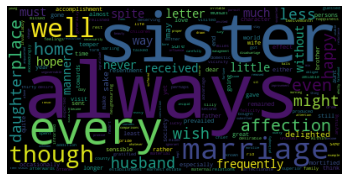

In [71]:
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

print(f'Plotting just the last chapter')
chapter = real[-1]
nopunct = chapter.translate(str.maketrans(punctuation, ' ' * len(punctuation)))
better = re.sub(nonprint, ' ', nopunct)
ok = clean.sub(' ', better) 
words = better.split()
draw = ' '.join([ w.lower() for w in words if w not in skip and w not in names and len(w) > 2 ])
cloud = WordCloud().generate(draw)
plt.imshow(cloud)
plt.axis('off')
plt.show()

Now we can do all chapters. (This will take a long time to process, though.)

Plotting in 8 by 8 grid


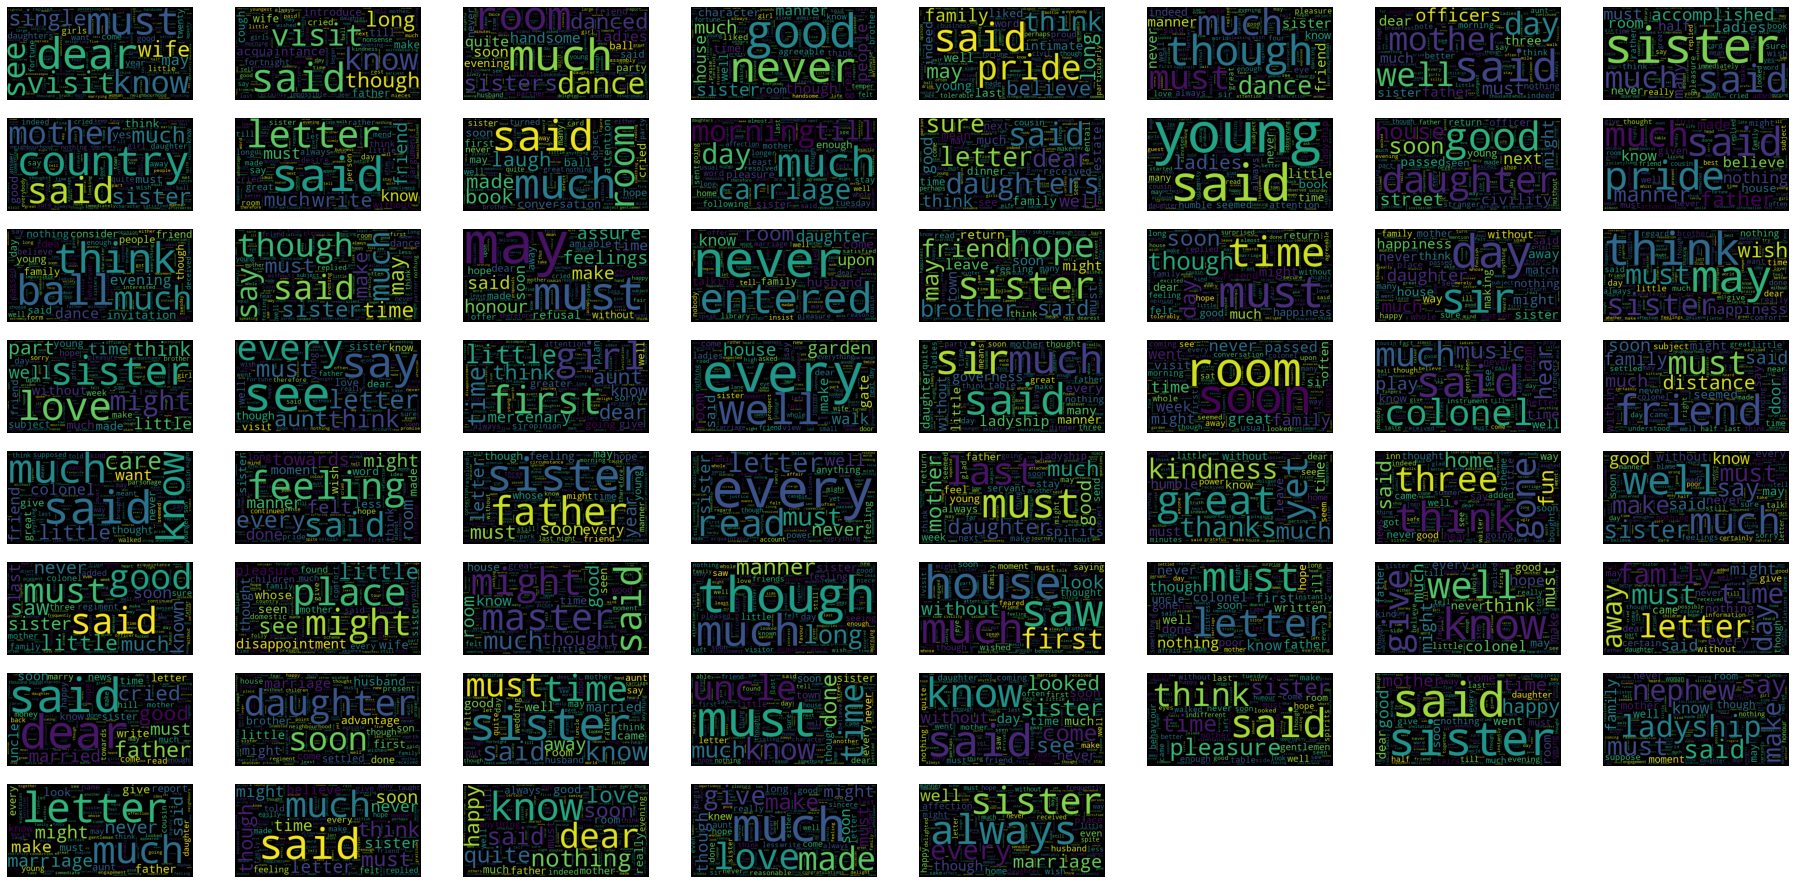

In [72]:
from math import sqrt, ceil
dim = int(ceil(sqrt(len(real))))
print(f'Plotting in {dim} by {dim} grid')
plt.rcParams['figure.figsize'] = [ 4 * dim, 2 * dim ]
f, a = plt.subplots(dim, dim)
r, c = 0, 0
for chapter in real:
  nopunct = chapter.translate(str.maketrans(punctuation, ' '*len(punctuation)))
  better = re.sub(nonprint, ' ', nopunct)
  ok = clean.sub(' ', better) 
  words = better.split()
  draw = ' '.join([ w.lower() for w in words if w not in skip and w not in names and len(w) > 2 ])
  cloud = WordCloud().generate(draw)
  a[r, c].imshow(cloud)
  c += 1 # fill by row
  if c == dim:
    c = 0
    r += 1
for r in range(dim):
  for c in range(dim):
      a[r, c].axis('off') # also make the unoccupied slots blank
plt.show()

To conclude our initial touch with how to deal with text in Python, let's build a *document-term matrix*, indicating per each chapter how often the words repeat in that document. In order to understand the process properly, we will populate in manually, just this once.

In [74]:
threshold = 150 # a word must appear at least this amount of times in total in the book to be included in the matrix 
# (we limit this just to make a smaller matrix that is easier to inspect visually, but we will see later why and when this may be counterproductive)
documents = real # the chapters are in our list called "real"
corpus = ' '.join( [chapter for chapter in real ]) # all the documents are combined here
terms = [ word for word in regular if len(word) > 2 and corpus.count(word) >= threshold ] # let's just use the regular words for now, not including the names
columns = len(terms) # terms are usually placed as columns
rows = len(documents) # documents are usually represented by rows
print(f'Populating a {rows} by {columns} term-document matrix')
import numpy as np
tdm = np.zeros((rows, columns))
r = 0
for document in documents:
  c = 0
  for term in terms:
    tdm[r, c] = document.count(term)
    c += 1
  r += 1
tdm

Populating a 61 by 100 term-document matrix


array([[3., 1., 1., ..., 1., 1., 0.],
       [2., 2., 0., ..., 0., 4., 1.],
       [1., 5., 7., ..., 3., 2., 1.],
       ...,
       [2., 0., 1., ..., 3., 3., 0.],
       [2., 1., 3., ..., 5., 5., 1.],
       [3., 0., 6., ..., 3., 4., 1.]])

This would be nicer to interpret if
- we could see the whole thing
- the documents and the terms were identified

In [75]:
import pandas as pd
dataframe = pd.DataFrame(tdm, columns = terms, index = [ f'Chapter {i}' for i in range(1, rows + 1) ])
dataframe

,little,turn,sister,ill,sent,give,pen,aught,per,use,...,every,nothing,ring,great,end,sure,let,ought,though,add
Chapter 1,3.0,1.0,1.0,12.0,1.0,1.0,1.0,4.0,4.0,3.0,...,0.0,0.0,2.0,0.0,7.0,5.0,1.0,1.0,1.0,0.0
Chapter 2,2.0,2.0,0.0,13.0,1.0,0.0,2.0,2.0,2.0,1.0,...,1.0,0.0,2.0,1.0,5.0,1.0,1.0,0.0,4.0,1.0
Chapter 3,1.0,5.0,7.0,6.0,3.0,2.0,2.0,4.0,2.0,1.0,...,2.0,2.0,4.0,3.0,7.0,2.0,1.0,3.0,2.0,1.0
Chapter 4,2.0,0.0,5.0,4.0,0.0,1.0,3.0,1.0,7.0,4.0,...,5.0,1.0,1.0,5.0,9.0,2.0,1.0,3.0,4.0,0.0
Chapter 5,1.0,0.0,1.0,2.0,1.0,2.0,1.0,0.0,4.0,6.0,...,4.0,1.0,4.0,2.0,6.0,3.0,0.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chapter 57,2.0,2.0,3.0,4.0,3.0,8.0,3.0,4.0,6.0,3.0,...,5.0,2.0,6.0,2.0,7.0,3.0,10.0,4.0,2.0,5.0
Chapter 58,2.0,2.0,6.0,13.0,6.0,11.0,4.0,6.0,18.0,7.0,...,6.0,2.0,6.0,3.0,11.0,6.0,9.0,9.0,14.0,4.0
Chapter 59,2.0,0.0,1.0,26.0,4.0,5.0,4.0,1.0,5.0,3.0,...,4.0,8.0,2.0,3.0,9.0,9.0,4.0,3.0,3.0,0.0
Chapter 60,2.0,1.0,3.0,18.0,2.0,6.0,1.0,0.0,8.0,5.0,...,3.0,0.0,2.0,4.0,7.0,5.0,4.0,5.0,5.0,1.0


Some of these totally should be stop words, right? We can go back and edit the list above and rerun the code for more informative results.